In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

https://towardsdatascience.com/image-generation-in-10-minutes-with-generative-adversarial-networks-c2afc56bfa3b

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input,
                                     Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten,
                                     UpSampling2D,
                                     Lambda)
import matplotlib.pyplot as plt

In [308]:
# underscore to omit the label arrays
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() 


train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256


In [309]:
len(train_images)

60000

In [310]:
import numpy as np

# 8 선택해서, 이것만 사용...
object_number = 5
train_images = train_images[np.where(train_labels == object_number)]
train_labels = train_labels[np.where(train_labels == object_number)]


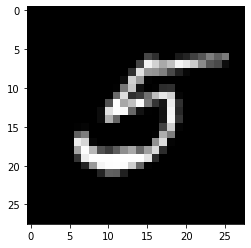

In [311]:
plt.imshow(train_images[102, :, :, 0], cmap='gray')

In [250]:
train_images2 = []
for i in range(5000):
    train_images2.append(train_images[102])
    
#500개만...
train_images = np.asarray(train_images2)
train_labels = train_labels[0:5000]


5000

In [312]:
BUFFER_SIZE = len(train_images)
BUFFER_SIZE

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [313]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [336]:
def make_generator_model():

    input = Input(shape=(100,), dtype='int32') 

    x1 = Dense(7*7*256, use_bias=False)(input)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU()(x1)
    x1 = Reshape((7, 7, 256))(x1)
    
    x1 = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x1)
    x1 = Reshape((7, 7, 128))(x1)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU()(x1)
    
    x1 = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x1)
    x1 = Reshape((14, 14, 64))(x1)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU()(x1)
    
    x1 = Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x1)
    x1 = Reshape((14, 14, 1))(x1)    

    x2 = UpSampling2D(size=(2, 2),interpolation='bilinear')(x1)

    model = Model(input,[x1,x2])

    model.summary()
    return model

generator = make_generator_model()

Model: "functional_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_75 (Dense)             (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_141 (Bat (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_197 (LeakyReLU)  (None, 12544)             0         
_________________________________________________________________
reshape_169 (Reshape)        (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_141 (Conv2D (None, 7, 7, 128)         819200    
_________________________________________________________________
reshape_170 (Reshape)        (None, 7, 7, 128)       

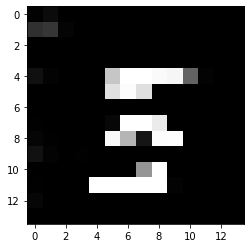

In [351]:
# Create a random noise and generate a sample
noise = tf.random.normal([10, 100])
#generated_image,generated_image2,generated_image3 = generator(noise, training=True)
generated_image, generated_image2 = generator(noise, training=True)
# Visualize the generated sample
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generated_image

In [337]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))
    model.summary()
    return model

discriminator = make_discriminator_model()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_200 (LeakyReLU)  (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_201 (LeakyReLU)  (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 6272)            

In [338]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [339]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 60
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])



In [340]:
import sys
# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    try:
        # 2 - Generate images and calculate loss values
        # GradientTape method records operations for automatic differentiation.
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          
          #generated_images,generated_images2,generated_images3 = generator(noise, training=True)
          generated_images,generated_images2 = generator(noise, training=True)
          #print(generated_images)
          #generated_image2 = tf.image.resize(generated_images, [28,28], method='bilinear')
          #print(generated_images3)
          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images2, training=True)

          disc_loss = discriminator_loss(real_output, fake_output)
          
          #noise2 = tf.random.normal([BATCH_SIZE, noise_dim])
          #generated_images,generated_images3 = generator(noise, training=True)
          #fake_output2 = discriminator(generated_images3, training=True)  
          gen_loss = generator_loss(fake_output)        
        # 3 - Calculate gradients using loss values and model variables
        # "gradient" method computes the gradient using 
        # operations recorded in context of this tape (gen_tape and disc_tape).
        
        # It accepts a target (e.g., gen_loss) variable and 
        # a source variable (e.g.,generator.trainable_variables)
        # target --> a list or nested structure of Tensors or Variables to be differentiated.
        # source --> a list or nested structure of Tensors or Variables.
        # target will be differentiated against elements in sources.

        # "gradient" method returns a list or nested structure of Tensors  
        # (or IndexedSlices, or None), one for each element in sources. 
        # Returned structure is the same as the structure of sources.
        gradients_of_generator = gen_tape.gradient(gen_loss, 
                                                  generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    discriminator.trainable_variables)
        
        # 4 - Process  Gradients and Run the Optimizer
        # "apply_gradients" method processes aggregated gradients. 
        # ex: optimizer.apply_gradients(zip(grads, vars))
        """
        Example use of apply_gradients:
        grads = tape.gradient(loss, vars)
        grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
        # Processing aggregated gradients.
        optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
        """
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    except Exception as ex:
        print(ex,sys.exc_info())
        raise ex

In [341]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [342]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  #predictions,predictions2,predictions3  = model(test_input, training=False)
  predictions, predictions2  = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

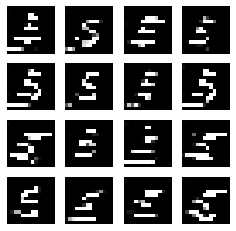

In [343]:
train(train_dataset, EPOCHS)

In [323]:
len(train_dataset)

22

In [344]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

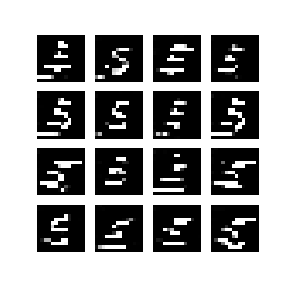

In [345]:
# PIL is a library which may open different image file formats
import PIL 
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

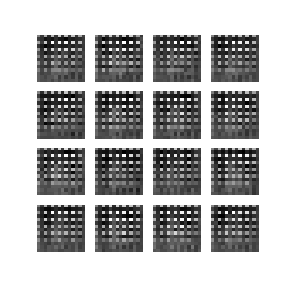

In [346]:
import glob # The glob module is used for Unix style pathname pattern expansion.
import imageio # The library that provides an easy interface to read and write a wide range of image data

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  # image = imageio.imread(filename)
  # writer.append_data(image)
  
display.Image(open('dcgan.gif','rb').read())